In [5]:
# set same dependency environment to ./Utils/Tracker.py, so python files in this script can access the same environment as Tracker.py
import sys
sys.path.append(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils')

from DDBSCAN import Raster_DBSCAN
from LiDARBase import *
from GenBckFile import *
from SaveTrajectoryTools import save_result
from ExamPcapStartTime import get_pcap_start_time
import pandas as pd
import os
from p_tqdm import p_umap
from functools import partial
from threading import Thread,Event
import matplotlib.pyplot as plt

In [76]:
pcap_file_path = r'D:\LiDAR_Data\US50ANDHighlands\2024-03-16-12-30-00.pcap'
tracking_parameter_dict = {
        'win_width': 13,
        'win_height': 7,
        'eps': 1,
        'min_samples': 10,
        'missing_thred': 5,
        'bck_radius': 0.2,
        'N' : 10,
        'd_thred' : 0.1,
    }
termination_event = Event()
thred_map = gen_bckmap(pcap_file_path, 
                        N = tracking_parameter_dict['N'],
                        d_thred = tracking_parameter_dict['d_thred'],
                        bck_n = 3,
                        termination_event = termination_event)
start_timestamp = get_pcap_start_time(pcap_file_path)
packets_gen = read_packets_offline(pcap_file_path)
frame_generator = parse_packets(packets_gen)

17987it [06:44, 44.48it/s]


In [80]:
UTC_time_diff = 0
if_save_point_cloud = True
point_cloud_path = r'D:\LiDAR_Data\Test'

In [238]:
mot = MOT(tracking_parameter_dict,thred_map)
mot.UTC_time_diff = UTC_time_diff
if if_save_point_cloud:
    mot.point_cloud_save_path = point_cloud_path
mot.start_timestamp = start_timestamp

In [239]:
while not mot.if_initialized:
    try:
        frame = next(frame_generator)
    except StopIteration:
        break
    mot.initialization(frame)

    if if_save_point_cloud:
        save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)
    # break

In [422]:
frame = next(frame_generator)
mot.mot_tracking_step(frame)
# save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)
fore_points = get_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,mot.Tracking_pool)
cur_frame = mot.CurFrame
cur_labeling_map = mot.cur_Labeling_map
cur_td_map = mot.cur_Td_map

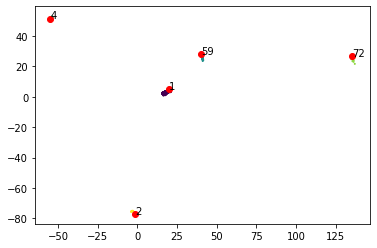

In [423]:
plt.scatter(fore_points[:,0],fore_points[:,1],s = 1,c = fore_points[:,3])
for key in mot.Tracking_pool.keys():
    if mot.Tracking_pool[key].label_seq[-1] != -1:
        plt.scatter(mot.Tracking_pool[key].mea_seq[-1][0][0][0],mot.Tracking_pool[key].mea_seq[-1][0][1][0],c = 'r')
        plt.text(mot.Tracking_pool[key].mea_seq[-1][0][0][0],mot.Tracking_pool[key].mea_seq[-1][0][1][0],str(key))
plt.show()

In [2]:
# point cloud is in .npy format [x,y,z,obj_label]
point_cloud_folder = r'D:\LiDAR_Data\US50ANDHighlands\test_point_cloud_out'
pc_folders = os.listdir(point_cloud_folder)
for folder in pc_folders:
    frame_names = os.listdir(os.path.join(point_cloud_folder, folder))
    total_point_clouds = []
    for frame in frame_names:
        point_cloud = np.load(os.path.join(point_cloud_folder, folder, frame))
        total_point_clouds.append(point_cloud)
    break
total_point_clouds_frame = np.concatenate(total_point_clouds, axis=0)

In [3]:
trajectory_data = pd.read_csv(r'D:\LiDAR_Data\US50ANDHighlands\test_traj_out\2024-03-16-12-30-00.csv')

In [9]:
fore_points[:,-1]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  5.,  5.,  5.,
        5.,  5.,  5.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  6.,  6.,
        6.,  6.,  6.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  6.,  6.,  6.,  6.,  6.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  9.,  9.,  9.,  9.,  9.,
        3.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

In [14]:
fore_points

array([[ 37.67868945,  12.68027994,  -3.71107076,   2.        ],
       [ 37.60557102,  12.50970847,  -3.6995457 ,   2.        ],
       [ 37.41065224,  12.29999662,  -3.67612379,   2.        ],
       ...,
       [ -7.44123488, -57.29433486,   1.68143287,  15.        ],
       [ -8.31174765, -57.67953284,   1.69597813,  15.        ],
       [ -8.79792529, -58.17357   ,   1.71226883,  15.        ]])

In [28]:
fore_points = np.load(r'D:\LiDAR_Data\US50ANDHighlands\test_point_cloud_out\2024-03-16-12-30-00\30.npy')


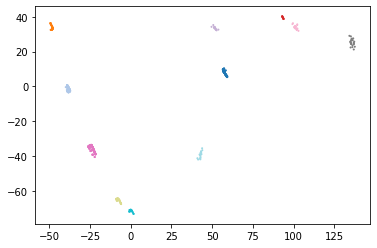

In [15]:
fore_points = np.load(r'D:\LiDAR_Data\US50ANDHighlands\test_point_cloud_out\2024-03-16-12-30-00\1.npy')
plt.scatter(fore_points[:,0],fore_points[:,1],s = 1,c = fore_points[:,3],cmap = 'tab20')
plt.show()